<a href="https://colab.research.google.com/github/Vernalhav/image_processing_project/blob/main/DetectAndClassify_Model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Useful Methods

In [ ]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
DEBUG = False
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import imutils

In [ ]:
def show_cvt(image, n):
  plt.figure(figsize=(n,n))
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

def show(image, n):
  plt.figure(figsize=(n,n))
  plt.imshow(image,15)  

def imshow_components(labels):
  # Map component labels to hue val
  label_hue = np.uint8(179*labels/np.max(labels))
  blank_ch = 255*np.ones_like(label_hue)
  labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

  # cvt to BGR for display
  labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

  # set bg label to black
  labeled_img[label_hue==0] = 0
  plt.figure(figsize=(10, 10))
  plt.imshow(labeled_img)
  plt.show()

def draw_box(img, north, west, height, width):
    east = west
    south = north
    east[1] += width
    south[1] += height

    cv2.line(img, (west[1], south[0]), (east[1], south[0]), (255, 0, 0), 5, 1)
    cv2.line(img, (west[1], north[0]), (east[1], north[0]), (255, 0, 0), 5, 1)
    cv2.line(img, (west[1], south[0]), (west[1], north[0]), (255, 0, 0), 5, 1)
    cv2.line(img, (east[1], north[0]), (east[1], south[0]), (255, 0, 0), 5, 1)

    return img

def extract_color_histogram(image, bins=(2, 2, 2)):
	# extract a 3D color histogram from the HSV color space using
	# the supplied number of `bins` per channel
	hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
	hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
		[0, 180, 0, 256, 0, 256])
	# handle normalizing the histogram if we are using OpenCV 2.4.X
	if imutils.is_cv2():
		hist = cv2.normalize(hist)
	# otherwise, perform "in place" normalization in OpenCV 3 (I
	# personally hate the way this is done
	else:
		cv2.normalize(hist, hist)
	# return the flattened histogram as the feature vector
	return hist.flatten()
def extract_sift(image):
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(gray,None)
    return des
def extract_sobel(image):
    NUM_FILTERS = 16
    gabor = []
    
    for i in range(NUM_FILTERS):
        gabor.append(cv2.getGaborKernel((5, 5), 8.0, (np.pi/NUM_FILTERS) * (i), 5.0, 0.5, 0, ktype=cv2.CV_32F))

    filtered = []
    # fig = plt.figure(figsize=(30,30))
    for i in range(NUM_FILTERS):
        filtered_img = cv2.filter2D(image,3,gabor[i])
        filtered_img = ((filtered_img/np.max(filtered_img))*255).astype(np.uint8)
        filtered_img = cv2.cvtColor(filtered_img, cv2.COLOR_BGR2GRAY)
        filtered_img = cv2.bitwise_not(filtered_img)
        # ax = fig.add_subplot(1,NUM_FILTERS,i + 1)
        # ax.imshow(filtered_img, cmap="gray")
        #resizing features
        filtered.append(cv2.resize(filtered_img, (10,10)))
    return np.array(filtered)

def characterize(img):
    img = cv2.resize(img,(30,30))
    
    #extract color and shape features
    colors = extract_color_histogram(img)
    # shapes = extract_sobel(img)


    # features = []
    # features = np.concatenate((features, colors.flatten()), axis=None)

    # for shape in shapes:
    #     features = np.concatenate((features, shape.flatten()), axis=None)
    
    return colors

## Reading Image


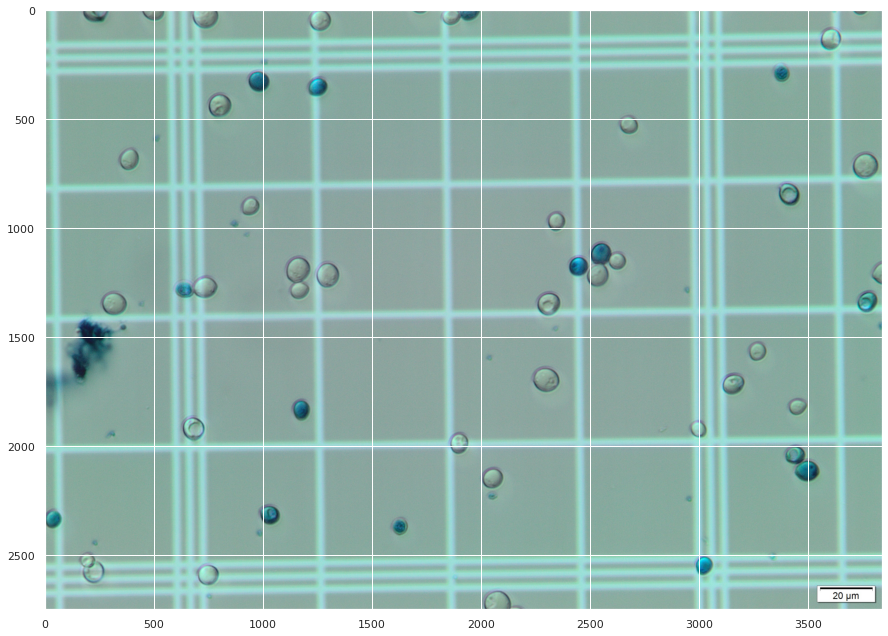

In [ ]:
img = cv2.imread("/drive/Shareddrives/PDI/Dataset/2/seq2_4_3.jpg")

if True:
    show_cvt(img, 15)

## Pre-processing Image

### Changing Color space

In [ ]:
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

if DEBUG:
    fig = plt.figure(figsize=(30,30))
    ax1 = fig.add_subplot(1,3,1)
    ax2 = fig.add_subplot(1,3,2)
    ax3 = fig.add_subplot(1,3,3)

    ax1.imshow(img_lab[:,:,0], cmap="gray")
    ax2.imshow(img_lab[:,:,1] , cmap="gray")
    ax3.imshow(img_lab[:,:,0] + img_lab[:,:,1], cmap="gray")

### Sharpenig A channel

In [ ]:
# channel = img_lab[:,:,0] + img_lab[:,:,1]

# _, sharpened = cv2.threshold(channel, 100, 121, cv2.THRESH_BINARY)

# if DEBUG:
#     fig = plt.figure(figsize=(30,30))
#     ax1 = fig.add_subplot(1,2,1)
#     ax2 = fig.add_subplot(1,2,2)
#     ax1.imshow(channel , cmap="gray")
#     ax2.imshow(img[:,:,1] + sharpened, cmap="gray")

### Look for cells

In [ ]:
#searching for circles around cells
circles = cv2.HoughCircles(img_lab[:,:,1] , 
                   cv2.HOUGH_GRADIENT, 1, 20, param1 = 50,
               param2 = 40, minRadius = 20, maxRadius = 55)

### Detecting overlapping circles

In [ ]:
#removing overlaid circles
circles_ord = list(circles.copy()[0])

circles_ord.sort(key=lambda tup: tup[2], reverse=True)

circles_ord = np.array(circles_ord)

cells = []

collided = False
for circle1 in circles_ord:
    for circle2 in cells:
        dist = np.sqrt( ( circle1[0] - circle2[0])**2 + (circle1[1] - circle2[1])**2 )

        #are they overlapping a lot?
        if dist < circle1[2] + circle2[2] and dist < max(circle1[2], circle2[2]):
            collided = True
            break
    if not collided:
        cells.append(circle1)
    else:
        collided = False

print(len(cells), len(circles[0]))    

AttributeError: ignored

## Applying the classifier

### Loading the model

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set()

In [ ]:
#loading the model
#loading the model
import pickle
knn = pickle.load(open('/drive/Shareddrives/PDI/Dataset/knnpickle_file_colors.pickle', 'rb'))

In [ ]:
cimg = img.copy()

margin = 20

dead_count = 0
alive_count = 0

#classifying the im-age crops

for i in cells:
    # draw the outer circle
    
    top = int(i[0] - i[2] - margin)
    left = int(i[1] - i[2] - margin)
    
    if top < 0:
        top = 0
    if left < 0:
        left = 0

    start_point = (top, left)
    end_point = (int(top+2*(i[2] + margin)), int(left+2*(i[2] + margin)))

    cell = img[start_point[1]:end_point[1], start_point[0]:end_point[0]]

    features = characterize(cell)
    label = knn.predict([features])
    thickness = 4

    if label == 'Dead':
        cimg = cv2.rectangle(cimg, start_point, end_point, (0,0,255), thickness)
        # cv2.circle(cimg,(i[0],i[1]),int(i[2] + margin),(0,0,255),-1)
        dead_count+=1
    else:
        cimg = cv2.rectangle(cimg, start_point, end_point, (0,255,0), thickness)
        # cv2.circle(cimg,(i[0],i[1]),int(i[2] + margin),(0,255,0),-1)
        alive_count+=1

total_cells = dead_count + alive_count

plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(cimg, cv2.COLOR_BGR2RGB))

print(f'\
Número total de células: {total_cells}\n\
Número total de células mortas: {dead_count} ({100*dead_count/total_cells:.2f}%)\n\
Número total de células vivas: {alive_count} ({100*alive_count/total_cells:.2f}%)')

In [ ]:
# img_size = 2
# img = cv2.imread("/drive/Shareddrives/PDI/Dataset/2/seq2_5_1.jpg")
# def findCentralBox(img):
#     from skimage.morphology import skeletonize

#     _, grid = cv2.threshold(img, 210, 255, cv2.THRESH_BINARY)

#     grid = cv2.cvtColor(grid, cv2.COLOR_BGR2GRAY)

#     kernel = cv2.getStructuringElement(cv2.MORPH_DILATE, (3,3))
#     morphed = cv2.morphologyEx(grid, cv2.MORPH_DILATE, kernel, iterations=50)
#     kernel = cv2.getStructuringElement(cv2.MORPH_OPEN, (5,5))
#     eroded = cv2.morphologyEx(morphed, cv2.MORPH_OPEN, kernel, iterations=35)
#     eroded[eroded > 0] = 1
#     eroded[eroded <= 0] = 0

#     # perform skeletonization
#     skeleton = skeletonize(eroded).astype(np.uint8)

#     # fill the central region
#     flood = cv2.floodFill(skeleton, None, (int(img.shape[0]/2), int(img.shape[1]/2)), newVal = (255,255,255))[1]
#     _, flood = cv2.threshold(flood, 210, 255, cv2.THRESH_BINARY)

#     cnts = cv2.findContours(flood, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     cnts = cnts[0] if len(cnts) == 2 else cnts[1]

#     min_area = 100
#     max_area = np.inf

#     if len(cnts) > 1:
#         print("Mais de um contorno encontrado.")
#         return None
#     else:
#         rect = cv2.minAreaRect(cnts[0])
#         box = cv2.boxPoints(rect)
#         box = np.int0(box)
#         return box

# #cv2.drawContours(img, [box], 0, color, thickness)

# print(findCentralBox(img))